In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as stats
import scipy.special as ss
import sortedcontainers as sc
import os
import tqdm
import pickle

### Load libraries

In [2]:
from statsmodels.discrete.discrete_model import NegativeBinomial as statsNB

In [3]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


In [4]:
import hapaseg.coverage_DP as dp_cov
import hapaseg.a_cov_DP as dp_a_cov

In [5]:
colors = mpl.cm.get_cmap("tab20").colors

In [6]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 30

### load debug model

In [15]:
with open('./debug_data/acdp_model.pickle', 'rb') as f:
    a_cov_dp = pickle.load(f)

clustering snapshots

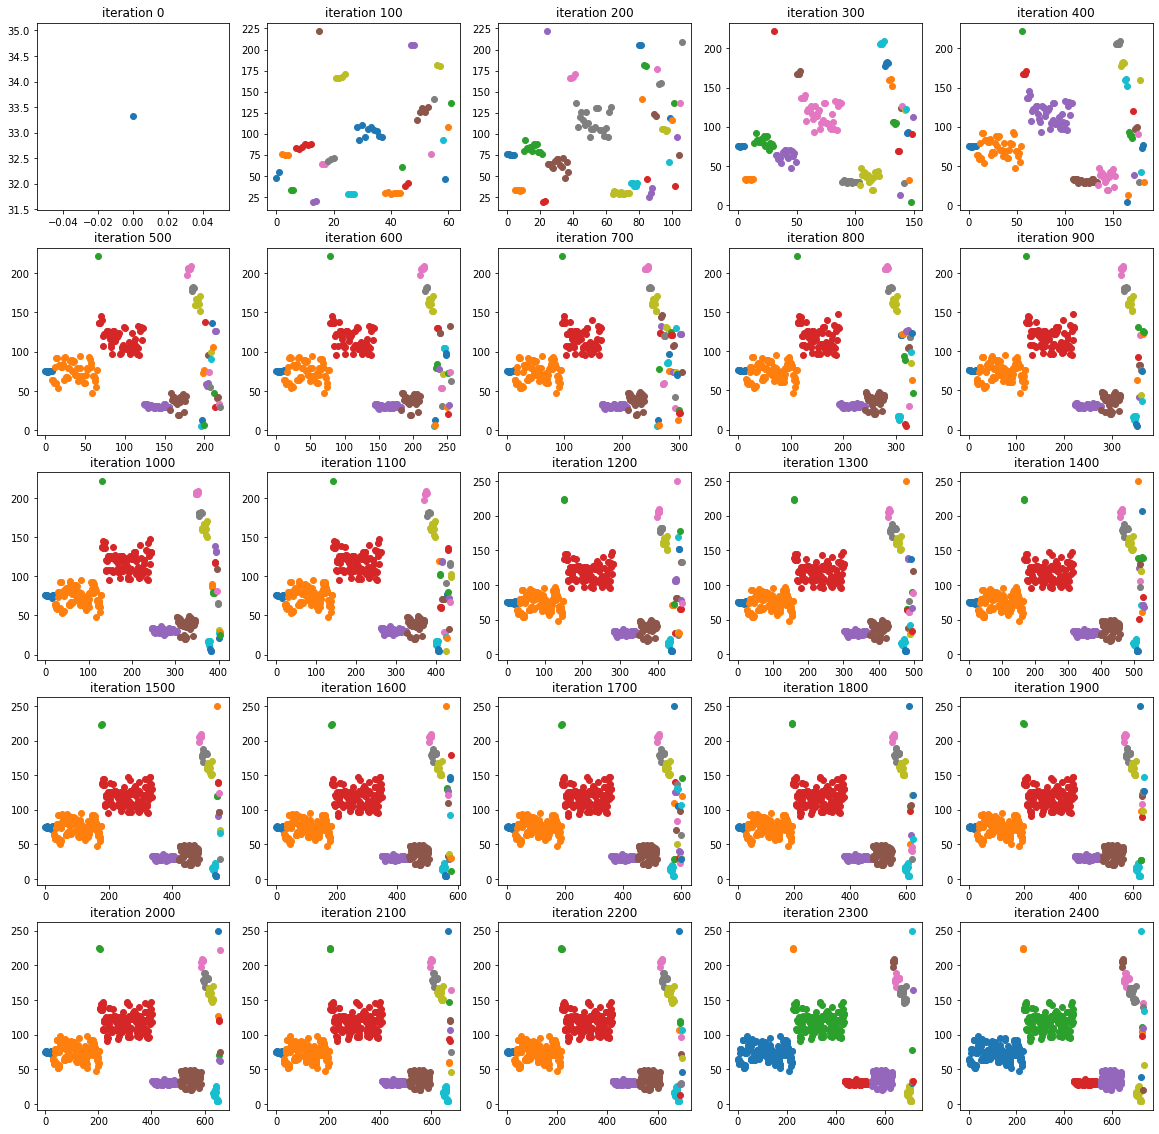

In [16]:
f, axs = plt.subplots(5,5,figsize=(20,20))
ax_lst = axs.flatten()
for i in range(25):
    counter=0
    for c in a_cov_dp.cdict_history[i]:
        vals = [np.array(a_cov_dp.segment_r_list[i]).mean() for i in a_cov_dp.cdict_history[i][c]]
        ax_lst[i].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
    ax_lst[i].set_title('iteration {}'.format(i*100))

these records are stored in a list of saved cluster_dict objects called .cdict_history. since the segment r values and segment IDs are consistent throughout the run we can fully recapitualte what the model was seeing at each step

lets take a closer look at the merging of the blue and brown clusters between iterations 100 and 200

In [18]:
#blue cluster is cluster 18 at index 10
[np.array(a_cov_dp.segment_r_list[seg]).mean() for seg in a_cov_dp.cdict_history[1][18]]

[107.70816578848581,
 92.55014485689307,
 110.06529610428373,
 96.73793952836282,
 105.21228891640523,
 108.66548635978529,
 104.19700601595241,
 102.92451480673571,
 97.42445686768247,
 95.75210835970961]

In [17]:
#brown cluster is cluster 26 at index 15
[np.array(a_cov_dp.segment_r_list[seg]).mean() for seg in a_cov_dp.cdict_history[1][26]]

[116.81830674732221,
 126.20757905571745,
 130.87708926825678,
 126.35001694195996,
 131.37250973407546]

In [29]:
#blue
#len, mean of tuples within cluster
[(len(a_cov_dp.segment_r_list[seg]), np.array(a_cov_dp.segment_r_list[seg]).mean()) for seg in a_cov_dp.cdict_history[1][18]]

[(8, 107.70816578848581),
 (8, 92.55014485689307),
 (25, 110.06529610428373),
 (3, 96.73793952836282),
 (45, 105.21228891640523),
 (239, 108.66548635978529),
 (33, 104.19700601595241),
 (30, 102.92451480673571),
 (43, 97.42445686768247),
 (4, 95.75210835970961)]

In [30]:
#brown
#len, mean of tuples within cluster
[(len(a_cov_dp.segment_r_list[seg]), np.array(a_cov_dp.segment_r_list[seg]).mean()) for seg in a_cov_dp.cdict_history[1][26]]

[(61, 116.81830674732221),
 (65, 126.20757905571745),
 (18, 130.87708926825678),
 (3, 126.35001694195996),
 (3, 131.37250973407546)]

we'll bring the ML calculation functions into the notebook to allow us to look at intermediate values and change hyperparameters. this is also necessary since these functions do not have acces to the cdict history

In [22]:
def _ML_cluster(self, cluster_set):
    r_lst = []
    V_lst = []
    for s in cluster_set:
        r_seg = self.segment_r_list[s]
        r_lst.append(r_seg)
        V_lst.append(self.segment_V_list[s])
    r = np.hstack(r_lst)
    V = np.hstack(V_lst)
    V_scale = (V * self.segment_cov_bins[cluster_set] / self.segment_cov_bins[cluster_set].sum()).sum()
    alpha = 0.001
    beta = alpha/2 * V_scale
    return self.ML_normalgamma(r, r.mean(), 1e-4, alpha, beta)

In [23]:
def DP_merge_prior(self, cdict, cur_cluster):
    cur_index = cdict.index(cur_cluster)
    cluster_vals = np.array([sum([len(self.segment_r_list[seg]) for seg in cdict[c]]) for c in cdict])
    N = cluster_vals.sum()
    M = cluster_vals[cur_index]
    prior_results = np.zeros(len(cluster_vals))
    for i, nc in enumerate(cluster_vals):
        if i != cur_index:
            prior_results[i] = ss.loggamma(M + nc) + ss.loggamma(N + self.alpha - M) - (ss.loggamma(nc) + ss.loggamma(N + self.alpha))
        else:
            prior_results[i] = ss.gammaln(M) + np.log(self.alpha) + ss.gammaln(N + self.alpha - M) - ss.gammaln(N + self.alpha)
    return prior_results

it ends up being the case that the light blue and orange singletons are more likely to merge withe the blue cluster than the brown cluster at first, so we'll speed things up by adding these to the blue cluster from get-go

In [19]:
snapshot1 = a_cov_dp.cdict_history[1].copy()

In [20]:
snapshot1[18].add(145)
snapshot1[18].add(196)
del snapshot1[37]
del snapshot1[35]

now we simulate what happens when we randomly pick cluster 18 in the gibbs sampler

In [31]:
self=a_cov_dp
clust_pick = 18
cdict = snapshot1
clust_pick_segs = np.r_[cdict[clust_pick]].astype(int)
# get ML of this cluster merged with each of the other existing clusters
ML_join = [
    _ML_cluster(self, cdict[i].union(clust_pick_segs)) if i != clust_pick else
    _ML_cluster(self, cdict[i]) for i in cdict]
# we need to compare this ML with the ML of leaving the target cluster and the picked cluster on their own
ML_split = np.array([_ML_cluster(self, cdict[i]) for i in cdict]) + _ML_cluster(self, cdict[clust_pick]) 
ML_split[cdict.keys().index(clust_pick)] = _ML_cluster(self, cdict[clust_pick])
ML_rat = np.array(ML_join) - ML_split

count_prior = DP_merge_prior(a_cov_dp, cdict, 18)

MLs_max = (ML_rat + count_prior).max()
choice_p = np.exp(ML_rat + count_prior - MLs_max) / np.exp(ML_rat + count_prior - MLs_max).sum()

In [32]:
# datapoints in each of the clusters
np.array([sum([len(self.segment_r_list[seg]) for seg in cdict[c]]) for c in cdict])

array([  15, 1951,  638,  473,   14,  200,    8,   63,  548,  129,  438,
       1926,   45,   56,  559,  150,  215,   84,  258,    8,   44])

In [37]:
ML_rat

array([ -344.53010987, -6210.18437881, -3676.03919163, -1014.30879031,
        -540.28694411, -1591.83448074,  -191.89180791,  -513.21609286,
       -2267.5278531 , -1272.59186541,     0.        , -8290.80626103,
        -546.02489579,  -760.35024431, -2754.44698128,  -319.12824617,
       -1059.62262234,  -594.42654455, -1493.65631739,  -303.85580499,
        -348.36687442])

In [33]:
ML_rat[[10,15]]

array([   0.        , -319.12824617])

In [34]:
count_prior[[10,15]]

array([-1690.84126776, -1354.80133107])

In [35]:
(ML_rat + count_prior)[[10,15]]

array([-1690.84126776, -1673.92957724])

In [36]:
choice_p[[10,15]]

array([4.52216191e-08, 9.99999955e-01])

the merging is about 17 likelihood points more likely dispite these clusters looking like they should remain apart!

Text(0.5, 1.0, 'datapoint level scatterplot of clusters 18 and 26')

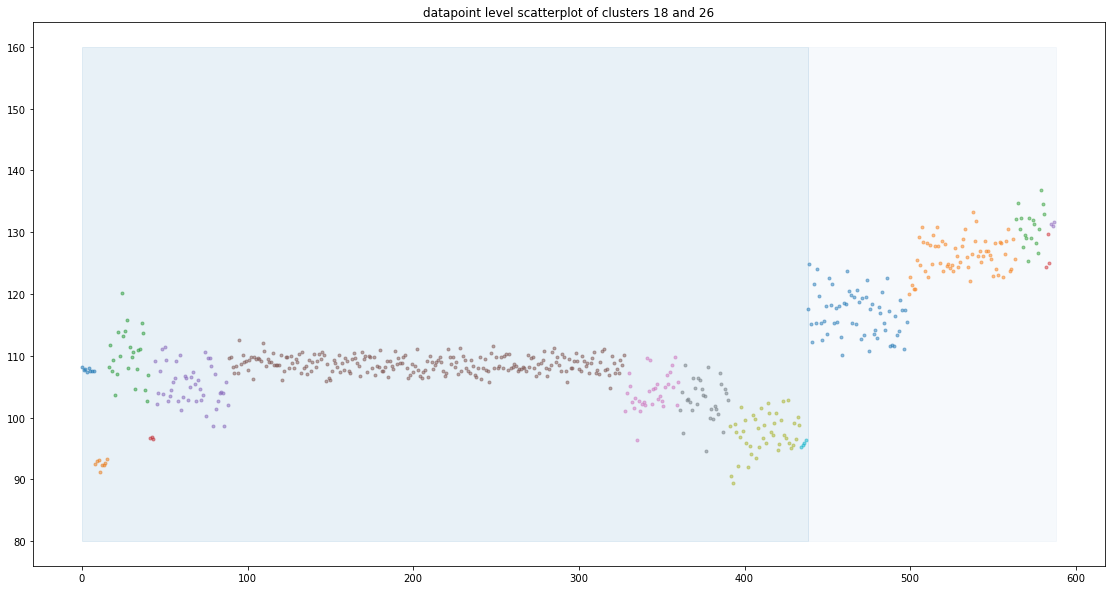

In [40]:
f, ax = plt.subplots(1, figsize = [19.2, 10])
counter=0
cc = 0
for c in [18,26]:
    c0 = counter
    vals = [np.array(a_cov_dp.segment_r_list[i]) for i in cdict[c]]
    
    for arr in vals:
        ax.scatter(np.r_[counter:counter+len(arr)], arr, marker = '.', alpha=0.5)
        counter+= len(arr)
    ax.add_patch(mpl.patches.Rectangle((c0,80), counter-c0, 80, fill=True, alpha=0.10, color = colors[cc % len(colors)]))
    cc+=1
ax.set_title('datapoint level scatterplot of clusters 18 and 26')

In [41]:
val_list = []
for c in [18,26]:
    vals = [a_cov_dp.segment_r_list[i] for i in cdict[c]]
    val_list.extend(vals)

Text(0.5, 1.0, 'histogram of cluster 18 and 26 datapoints')

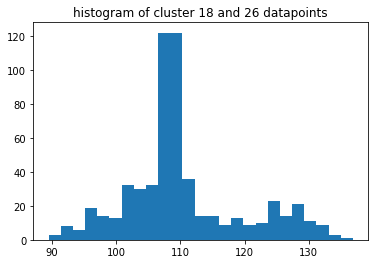

In [43]:
_ = plt.hist(np.hstack(val_list), bins=25)
plt.title('histogram of cluster 18 and 26 datapoints')